In [1]:
import os
import bye_cycle
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle

In [2]:
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
# Disabling GPU
RUN_ON_GPU = True
if not RUN_ON_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=32*1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [4]:
dat = []
for file in os.listdir('CACHED_DATA/'):
    if file.startswith("cell"):
        with open(f'CACHED_DATA/{file}', 'rb') as f:
            cell_data = np.array(pickle.load(f))[0]
        dat.append(cell_data)
print('CACHED data is loaded.')

CACHED data is loaded.


In [5]:
# data_prep
def prep_ml_data(dat):
    features = np.empty([0, 100, 3])
    labels = np.empty([0])
    for d in tqdm(dat):
        cell_features = d[:-1, :, :3] # drop the last cycle
        cell_labels = np.array([d[i, 0, -1] for i in range(1, d.shape[0])]) # drop the first cycle
        features = np.append(features, cell_features, axis=0)
        labels = np.append(labels, cell_labels, axis=0)
    return features, labels


In [6]:
np.random.choice(np.arange(len(dat)),10)

array([134, 279, 218, 100, 280,  43, 232, 217,  84,  26])

In [7]:
import random
random.seed(0)
indices = list(range(len(dat)))
random.shuffle(indices)
train_size = 0.9
val_size = 0.09
N_train = int(train_size *len(dat))
N_val = int(val_size *len(dat))
train_dat = dat[:N_train]
# train_indices = random.sample(range(len(dat)), N_train)
test_dat = dat[N_train:]
val_dat = test_dat[:N_val]
test_dat = test_dat[N_val:]

# val_indices = random.sample(list(range(len(dat))).pop(train_indices), N_val)
# N_test = len(dat) - N_train - N_val

In [8]:
train_features, train_labels = prep_ml_data(train_dat)
val_features, val_labels = prep_ml_data(val_dat)
test_features, test_labels = prep_ml_data(test_dat)

100%|██████████| 5/5 [00:00<00:00, 216.09it/s]


In [22]:
def standardize(inputs):
    fstd = np.std(inputs, axis=0)
    fmean = np.mean(inputs, axis=0)
    std_features = (inputs - fmean) / fstd
    return std_features
std_train_features = standardize(train_features)
std_test_features = standardize(test_features)
std_val_features = standardize(val_features)

In [43]:
from dataclasses import dataclass
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(train_labels), 
                batch_size=512, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

In [70]:
# [:,:,:2]
np.random.seed(0)
i = np.arange(len(train_features))
np.random.shuffle(i)
train_data = tf.data.Dataset.from_tensor_slices((std_train_features[i], train_labels[i])).batch(config.batch_size)
i = np.arange(len(val_features))
val_data = tf.data.Dataset.from_tensor_slices((std_val_features[i], val_labels[i])).batch(config.batch_size)
i = np.arange(len(test_features))
test_data = tf.data.Dataset.from_tensor_slices((std_test_features[i], test_labels[i])).batch(config.batch_size)
N = len(dat)
# C = train_features.shape[2]
T = train_features.shape[1]
L = 3 # train_features.shape[-1]

In [82]:
def build_model(T, L):
    inputs = tf.keras.Input(shape=(T, L))
    print(f'input: {inputs.shape}')
    conv_1d_layer = tf.keras.layers.Conv1D(128, 100)
#     blstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
#     x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(100, 3))(inputs)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
#     x = tf.keras.layers.Reshape((100, 64))(x)
#     print(f'output CNN 1: {x.shape}')
#     conv_1d_layer = tf.keras.layers.Conv1D(64, 5, input_shape=(100,64))
#     x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(100,))(x)
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(inputs)
    print(x.shape)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
#     x = tf.keras.layers.Dense(16, activation='relu')(x)
#     e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
#                                     output_dim=config.embedding_dim,
#                                     mask_zero=True)(inputs)
    yhat = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[inputs], outputs=yhat)
    return model

In [83]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9216      
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14,433
Trainable params: 14,433
Non-trainable params: 0
_________________________________________________________

In [84]:
tf.keras.backend.clear_session()
model = build_model(T, L)
opt = tf.optimizers.Adam(1e-2)
model.compile(
  opt,
  loss='mean_squared_error')

input: (None, 100, 3)
(None, 64)


In [85]:
train_features.shape

(471612, 100, 3)

In [86]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
        ), tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', restore_best_weights=True, patience=10)],
# #         tf.keras.callbacks.LambdaCallback(
# #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# #         ),
#         ,
    epochs=150)

Epoch 1/150
922/922 [==============================] - 41s 41ms/step - loss: 0.1494 - val_loss: 0.4873 - lr: 0.0100
Epoch 2/150
922/922 [==============================] - 36s 39ms/step - loss: 0.0969 - val_loss: 0.4584 - lr: 0.0100
Epoch 3/150
922/922 [==============================] - 36s 39ms/step - loss: 0.0802 - val_loss: 0.5474 - lr: 0.0100
Epoch 4/150
922/922 [==============================] - 36s 39ms/step - loss: 0.0678 - val_loss: 0.6170 - lr: 0.0100
Epoch 5/150
922/922 [==============================] - 36s 39ms/step - loss: 0.0641 - val_loss: 0.6303 - lr: 0.0100
Epoch 6/150
922/922 [==============================] - 36s 39ms/step - loss: 0.0646 - val_loss: 0.6089 - lr: 0.0100
Epoch 7/150
922/922 [==============================] - 36s 39ms/step - loss: 0.0602 - val_loss: 0.5202 - lr: 0.0100
Epoch 8/150
922/922 [==============================] - 36s 39ms/step - loss: 0.0570 - val_loss: 0.5490 - lr: 0.0090
Epoch 9/150
922/922 [==============================] - 36s 39ms/step - l

KeyboardInterrupt: 

In [ ]:
plt.figure(dpi=100)
plt.plot(result.history['loss'], color='C0', label='Train')
plt.plot(result.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epochs')

In [76]:
test_result = model.evaluate(test_data)

20/20 [==============================] - 0s 15ms/step - loss: 0.6595


(array([1.169e+05, 7.382e+04, 6.194e+04, 1.266e+05, 7.346e+04, 1.732e+04,
        1.589e+03, 6.000e+00, 3.000e+00, 3.000e+00]),
 array([1.886e-04, 7.544e-01, 1.509e+00, 2.263e+00, 3.017e+00, 3.771e+00,
        4.525e+00, 5.280e+00, 6.034e+00, 6.788e+00, 7.542e+00]),
 <BarContainer object of 10 artists>)

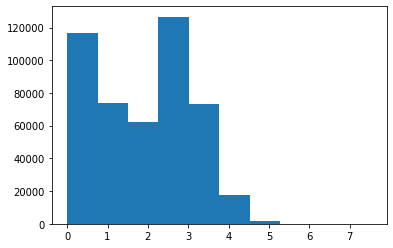

In [18]:
import matplotlib.pyplot as plt
plt.hist(train_labels)

In [19]:
train_features.shape

(471612, 100, 3)

In [20]:
fstd = np.std(train_features, axis=0)
fmean = np.mean(train_features, axis=0)
std_features = (train_features - fmean) / fstd

In [ ]:
stan

In [21]:
std_features.shape

(471612, 100, 3)

In [42]:
cycle_1 = dat[0]
labels_1 = np.array([cycle_1[i, 0, -1] for i in range(1,cycle_1.shape[0])])

(120, 100, 4)

In [55]:
cycle = dat[10]
labels = np.array([cycle[i, 0, -1] for i in range(1,cycle.shape[0])])
for m,n in zip(labels_1, labels):
    print(m,n)

4.679043769836426 4.063972473144531
4.67928409576416 4.057681083679199
4.677210807800293 4.054137229919434
4.6732025146484375 4.050907611846924
4.669522762298584 4.047037124633789
4.667201519012451 4.0441131591796875
4.664853096008301 4.041234970092773
4.6590800285339355 4.037606716156006
4.6540117263793945 4.034421443939209
4.648177146911621 4.030792713165283
4.644162654876709 4.026839733123779
4.638237953186035 4.023080348968506
4.632976531982422 4.019033908843994
4.626867771148682 4.01548957824707
4.620232582092285 4.011753559112549
4.614728927612305 4.008667945861816
4.609258651733398 4.005490779876709
4.601845741271973 4.002580642700195
4.596648693084717 3.9993133544921875
4.592094421386719 3.996623992919922
4.583608627319336 3.9935522079467773
4.578281402587891 3.990145444869995
4.572017192840576 3.988149881362915
4.565342426300049 3.984947681427002
4.558945655822754 3.981903553009033
4.551966190338135 3.97884202003479
4.544899940490723 3.9764208793640137
4.538436412811279 3.9735

In [29]:
cycle_1 = dat[0]
labels_1 = np.array([cycle_1[i, 0, -1] for i in range(1,cycle_1.shape[0])])

In [35]:
cycle_2 = dat[1]
labels_2 = np.array([cycle_2[i, 0, -1] for i in range(1,cycle_2.shape[0])])

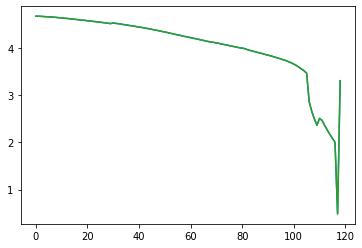

In [38]:
import matplotlib.pyplot as plt
plt.plot(labels_1,color='C0')
plt.plot(labels_2, color='C2')

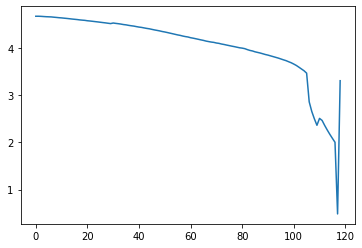

In [37]:
plt.plot(labels_2)

In [13]:
labels_file_name = 'labels.pkl'
with open(f'../../{labels_file_name}', 'rb') as f:
    labels = np.array(pickle.load(f))
    print('CACHED data is loaded for labels.')

CACHED data is loaded for labels.


In [14]:
labels.shape

(377,)